<center>    
    <h1 id='spacy-notebook-5' style='color:#7159c1; font-size:350%'>Introduction to Word Embeddings</h1>
    <i style='font-size:125%'>The basics of Word Embeddings</i>
</center>

> **Topics**

```
- 📘 Distributional Hypothesis
- 📖 Distributional Hypothesis - Syntagmatic Structure
- 📖 Distributional Hypothesis - Paradigmatic Structure
- 🛻 Simple Exploration of Transformers
```

<h1 id='0-distributional-hypothesis' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>📘 | Distributional Hypothesis</h1>

Linguistic Elements, such as words, may be characterized by their distribution in the linguistic system. With it, given the verb 'to enjoy', we can think of words that are likely (have more probability) to come after and before it, as well as, think of other verbs to replace 'to enjoy' and keep the same meaning, such as 'to like'.

These things can be achieve through `Distributional Hypothesis`, that can be applied in two ways, `Syntagmatic Structure` and `Paradigmatic Structure`, being:

- **Syntagmatic Structure** - `analyses the probability of a word coming before or after a certain word in order to form a sentence. So, we can say that it analyses how words relate with them to form meaning sentences. Changing the order of the words might change or lose the whole meaning of a sentence. Besides, it's essential for Dependency Label and Part-of-Speech (POS) Tagging`;

- **Paradigmatic Structure** - `analyses the probability of a word to be replaced by another one and the meaning of the sentence be kept the same. So, we can say that it analyses how words can be replaced for one another while keeping the same meaning and context, so, it's about word choices`.

In [1]:
import warnings
warnings.filterwarnings('ignore')

<h1 id='1-distributional-hypothesis-syntagmatic-structure' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>📖 | Distributional Hypothesis - Syntagmatic Structure</h1>

As seen before, in `Syntagmatic Structure` we analyse the probability of a word coming before or after a certain word in order to form sentences with meaning, as well as Dependency Label and Part-of-Speech (POS) Tagging.

In order to achieve it, we first should create a dataset containing all word lemmas (it's easier to work with lemmas rather than words in order to standard our data and turn the Bag-of-Words smaller and simpler), than we count the frequency of each lemma from all documents and then we calculate the similarity between each lemma-pairs (we will be sticking to Cosine Similarity in this notebook).

In this notebook, we will be doing the simpler Syntagmatic Structure analysis, however, in a real world application, we should do some steps in order to achieve better results, such as:

- Convert Words to their Lemma/Dictioanry Form (Lemmatization);
  
- Create a Bag-of-Words;
  
- Transform the Bag-of-Words into a Pandas\Polars DataFrame (Word Vectors per Document);
  
- Calculate the Frequency of each Word into the Document;
  
- Calculate the Cosine Similarity between the Documents by the Word Frequency;
  
- We can remove Stop Words to only consider relevant words into Bag-of-Words;
  
- We can add Weights to the Frequencies with TF-IDF (Term Frequency - Inverse Document Frequency) taking ZIPF Law into consideration.

Let's see in a practical example using `Polars` package!!

In [2]:
# Processing Documents
import spacy

nlp_en_large = spacy.load('en_core_web_lg')

texts = [
  'Helsinki is the capital of Finland'
  , 'Tallinn is the capital of Estonia'
  , 'The two capitals are joined by a ferry connection'
  , 'Travelling between Helsinki and Tallinn takes about two hours'
  , 'Ferries depart from downtown Helsinki and Tallinn'
]

documents = list(nlp_en_large.pipe(texts))

In [3]:
# Counting Lemmas and Creating Word Vector for Each Document
from spacy.attrs import LEMMA
import polars as pl

lemma_counts = { index: document.count_by(LEMMA) for index, document in enumerate(documents) }
lemma_counts = {
    index: { documents[index].vocab[key].text: value for key, value in counter.items() }
    for index, counter in lemma_counts.items()
}
lemma_counts = [{**value} for key, value in lemma_counts.items()]

In [8]:
# Creating DataFrame from Word Vectors
#
#  - realize that 'polars' doesn't work with index in its DataFrames, so we can just ignore it
#
lemma_counts_df = pl.DataFrame(lemma_counts) \
  .fill_null(strategy='zero')                \
  .transpose(
      include_header=True
      , header_name='index'
      , column_names=[f'document_{index}' for index in range(0, len(lemma_counts))]
  )

lemma_counts_df

index,document_0,document_1,document_2,document_3,document_4
str,i64,i64,i64,i64,i64
"""Helsinki""",1,0,0,1,1
"""be""",1,1,1,0,0
"""the""",1,1,1,0,0
"""capital""",1,1,1,0,0
"""of""",1,1,0,0,0
…,…,…,…,…,…
"""about""",0,0,0,1,0
"""hour""",0,0,0,1,0
"""depart""",0,0,0,0,1


In [9]:
# Calculating Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(lemma_counts_df[:, 1:6].to_numpy())
similarities

array([[1.        , 0.33333333, 0.33333333, 0.33333333, 0.40824829,
        0.57735027, 0.66666667, 0.        , 0.40824829, 0.        ,
        0.        , 0.        , 0.40824829, 0.        , 0.57735027,
        0.57735027, 0.81649658, 0.57735027, 0.57735027, 0.57735027,
        0.57735027, 0.57735027, 0.57735027],
       [0.33333333, 1.        , 1.        , 1.        , 0.81649658,
        0.57735027, 0.33333333, 0.57735027, 0.40824829, 0.57735027,
        0.57735027, 0.57735027, 0.40824829, 0.57735027, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.33333333, 1.        , 1.        , 1.        , 0.81649658,
        0.57735027, 0.33333333, 0.57735027, 0.40824829, 0.57735027,
        0.57735027, 0.57735027, 0.40824829, 0.57735027, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.33333333, 1.        , 1.        , 1.   

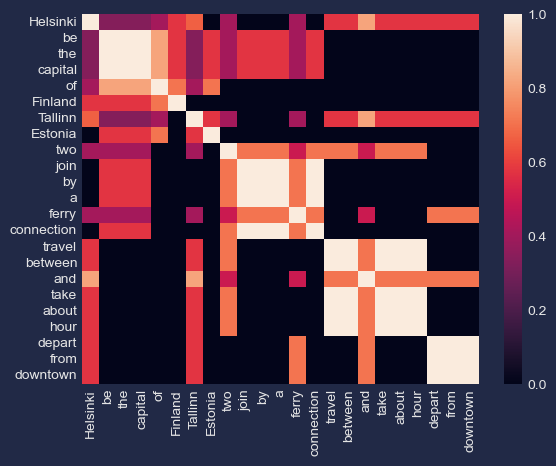

In [10]:
# Plotting
import matplotlib.pyplot as plt
import mplcyberpunk
import seaborn as sns

words = lemma_counts_df[:, 0].to_numpy()

sns.set_style('darkgrid')
plt.style.use('cyberpunk')

sns.heatmap(similarities, xticklabels=words, yticklabels=words)
plt.show()

Analysing the similarities above, let's take a look at the right bottom corner. We see that `downtown` and `from` have a high similarity, indicating that there's a high probability that `from` will come before `downtown` and `downtown` will come after `from` in a sentence.

On the other hand, taking a look at the left bottom corner, we realize that `downtown` and `capital` have low similarity, indicating that there's a low probability that `capital` will come before `downtown` and `downtown` will come after `capital` in a sentence.

<h1 id='2-distributional-hypothesis-paradigmatic-structure' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>📖 | Distributional Hypothesis - Paradigmatic Structure</h1>

In `Paradigmatic Structure`, we analyze the probability of a word to be replaced by another one and the meaning and context of the sentence be kept the same.

To achieve it, we first must list all unique lemmas from the documents, define the minimum and maximum distance of the Tokens in order to them be considered `neighbors`, count the frequency of neighbors for each Token, and then calculate the similarity between the Tokens (for this task, we will use Cosine Similarity).

The most similar the Tokens are, the most we can replace the words and keep the same meaning and context of the sentence!!

In [11]:
# Counting Unique Lemmas
unique_lemmas = lemma_counts_df['index'].to_list()

unique_lemmas_df = pl.DataFrame(
    schema=[(column, pl.Int64) for column in unique_lemmas]
    , data={column: [0] * len(unique_lemmas) for column in unique_lemmas}
).insert_column(0, pl.Series('index', unique_lemmas))

unique_lemmas_df

index,Helsinki,be,the,capital,of,Finland,Tallinn,Estonia,two,join,by,a,ferry,connection,travel,between,and,take,about,hour,depart,from,downtown
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Helsinki""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""be""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""the""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""capital""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""of""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""about""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""hour""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""depart""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# Counting Neighbors for Each Token
from spacy.tokens import Doc

combined_documents = Doc.from_docs(documents)
neighbor_distances = [-2, -1, 1, 2]

for token in combined_documents:
    for distance in neighbor_distances:
        try:
            neighbor_lemma = token.nbor(distance).lemma_

            unique_lemmas_df = unique_lemmas_df.with_columns(
                pl.when(pl.col('index') == neighbor_lemma) # returns 'True' or 'False' for each row accordingly to the given condition
                  .then(pl.col(token.lemma_) + 1)          # when 'True', updates the value accordingly to the given parameter
                  .otherwise(pl.col(token.lemma_))         # when 'False', updates the value by the given parameter, in this scenario, we are keeping the current value
                  .alias(token.lemma_)                     # forces the column name be the given parameter, in this scenario, we are forcing the column name be kept the same
            )
        except IndexError: continue

unique_lemmas_df

index,Helsinki,be,the,capital,of,Finland,Tallinn,Estonia,two,join,by,a,ferry,connection,travel,between,and,take,about,hour,depart,from,downtown
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
"""Helsinki""",0,1,1,0,0,0,2,0,0,0,0,0,0,0,1,1,2,0,0,0,0,1,1
"""be""",1,0,2,3,0,1,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
"""the""",1,2,0,3,3,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"""capital""",0,3,3,0,2,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
"""of""",0,0,3,2,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""about""",0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0
"""hour""",0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0
"""depart""",0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1


In [14]:
# Calculating Cosine Similarity between Tallinn and Helsinki
tallinn_lemma_vector = unique_lemmas_df['Tallinn'].to_numpy()
helsinki_lemma_vector = unique_lemmas_df['Helsinki'].to_numpy()
similarity = cosine_similarity([tallinn_lemma_vector], [helsinki_lemma_vector])
similarity

array([[0.42857143]])

Given the documents and analysing the similarity between `Helsinki` and `Tallinn`, even though both are capitals, their similarity is low (`~42.8571%`), so it's not a good idea to replace 'Helsinki' by 'Tallinn', and vice-versa.

<h1 id='3-simple-exploration-of-transformers' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>🛻 | Simple Exploration of Transformers</h1>

Spacy contains four Language Models (LM) for English, the small (`en_core_web_sm`), middle (`en_core_web_md`), large (`en_core_web_lg`) and transformer (`en_core_web_trf`).

Let's say that the first three ones (`small, middle and large`) are `Static Language Models`, that is, they cannot identify words with different meanings, such as the word `duck` as a verb and as a noun, since the word vector of both tokens will be the same.

In order to avoid this problem, we can get advantage os `Transformers (trf)!!`. They give us more accuracy, on the other hand, require more computation cost and power.

In [15]:
# Exploring a Statitc Model Word Vector
#
#  - Spacy provides a 300-dimensional word vector embedding
#
document = nlp_en_large('Hey it\'s me, Goku and he\'s Vegeta!')
goku_token_word_vector = document[5]
vegeta_token_word_vector = document[9]
similarity = goku_token_word_vector.similarity(vegeta_token_word_vector)

print(f'- Cosine Similarity Between \'Goku\' and \'Vegeta\': {similarity}')

- Cosine Similarity Between 'Goku' and 'Vegeta': 0.883222222328186


In [16]:
# Exploring Transformers Word Vector
#
#  - Spacy provides a 768-dimensional transformer vector
#
nlp_en_transformer = spacy.load('en_core_web_trf')
document = nlp_en_transformer('Hey it\'s me, Goku and he\'s Vegeta!')

document_transformer_vector = document._.trf_data
goku_token_transformer_vector = document._.trf_data.all_outputs[0][5]
vegeta_token_transformer_vector = document._.trf_data.all_outputs[0][9]

similarity = cosine_similarity(
    goku_token_transformer_vector.data
    , vegeta_token_transformer_vector.data
)

print(f'- Cosine Similarity Between \'Goku\' and \'Vegeta\': {similarity}')

- Cosine Similarity Between 'Goku' and 'Vegeta': [[0.7608766]]


---

<h1 id='reach-me' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>📫 | Reach Me</h1>

> **Email** - [csfelix08@gmail.com](mailto:csfelix08@gmail.com?)

> **Linkedin** - [linkedin.com/in/csfelix/](https://www.linkedin.com/in/csfelix/)

> **GitHub:** - [CSFelix](https://github.com/CSFelix)

> **Kaggle** - [DSFelix](https://www.kaggle.com/dsfelix)

> **Portfolio** - [CSFelix.io](https://csfelix.github.io/).